In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS,ImageColorGenerator
from collections import Counter
import string

## TODO: usar string.punctuation para limpiar signos de puntuación

In [42]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [2]:
%matplotlib inline

In [3]:
datos_originales = pd.read_excel("RESPUESTAS_ENCUESTA.xlsx",sheet_name="DATOS ORIGINALES")

In [38]:
stopwords = set(["con","como","no","de","y","en","el","a","que","para","la",
                 "mas","un","una","los","puede","o","las","es","al","se","más",
                 "si","del","por"])

In [43]:
def analisis_frecuencia_palabras(corpus):
    corpus = corpus.lower()
    corpus_list = corpus.split()
    vocabulario = set(corpus_list)
    conteo_corpus = Counter(corpus_list)
    conteo_corpus   = Counter({key: conteo_corpus[key] for key in conteo_corpus if key not in stopwords})
    
    palabra,conteo  = zip(*conteo_corpus.most_common())
    plt.barh(palabra[:10],conteo[:10])
    plt.show()
    
    wordcloud_primera_pregunta = WordCloud(stopwords=stopwords).generate(corpus)
    plt.imshow(wordcloud_primera_pregunta,interpolation="bilinear")
    plt.show()
    
    return corpus_list,vocabulario


In [44]:
preguntas_abiertas = datos_originales[datos_originales.columns[4:]]

corpus_global = ""

for column in preguntas_abiertas.columns:
    corpus_global = corpus_global + preguntas_abiertas[column].str.cat(sep=" ")
    

### Análisis de frecuencia global

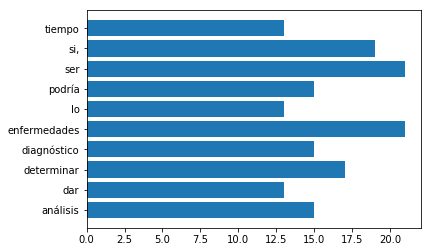

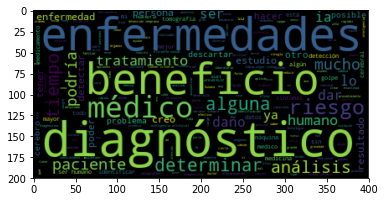

In [46]:
resultado =  analisis_frecuencia_palabras(corpus_global)


Podemos observar algunas cosas interesantes
* "diagnóstico" es predominante, lo cual indica que se cree que la IA puede ser usada para diagnóstico.
* "beneficio" es también predominante, la percepción hacía la IA es mayormente positiva, aun que podemos ver que también esta presente la palabra "riesgo" , se necesita analizar no por palabras si no por n-gramas para ver que palabras acompañan a riesgo, con el objetivo de determinar si en conjunto con otras palabras la muestra expresa que considera que existirá una disminución de riesgo o bien si consieran a la IA riesgosa.
* "enfermedades" es otra palabra predominante ,algo posiblemente de esperarse y posiblemente asociado con "diagnóstico"

## Pregunta 1:  ¿Qué beneficios cree usted que puede tener esta inteligencia artificial en el campo de la medicina?

### Análisis de frecuencia de palabras

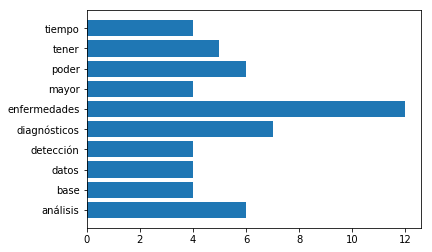

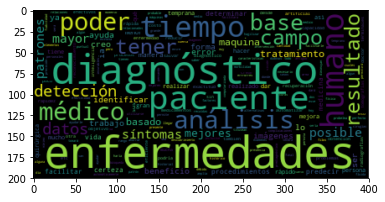

In [51]:
resultados_pregunta1 = datos_originales["¿Qué beneficios cree usted que puede tener esta inteligencia artificial en el campo de la medicina?"]
pregunta1_corpus = resultados_pregunta1.str.cat(sep=" ")
resultado = analisis_frecuencia_palabras(pregunta1_corpus)